In [199]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [200]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [201]:
import os
def walk_through_dir(dir_path):
    for dirpath,dirnames,filenames in os.walk(dir_path):
        print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

In [202]:
walk_through_dir('Datasets/pizza_steak_sushi/')

There are 2 directories and 0 images in Datasets/pizza_steak_sushi/
There are 3 directories and 0 images in Datasets/pizza_steak_sushi/test
There are 0 directories and 25 images in Datasets/pizza_steak_sushi/test\pizza
There are 0 directories and 19 images in Datasets/pizza_steak_sushi/test\steak
There are 0 directories and 31 images in Datasets/pizza_steak_sushi/test\sushi
There are 3 directories and 0 images in Datasets/pizza_steak_sushi/train
There are 0 directories and 78 images in Datasets/pizza_steak_sushi/train\pizza
There are 0 directories and 75 images in Datasets/pizza_steak_sushi/train\steak
There are 0 directories and 72 images in Datasets/pizza_steak_sushi/train\sushi


In [203]:
from pathlib import Path
data_path = Path('Datasets/')
image_path = data_path / "pizza_steak_sushi"

In [204]:
train_dir = image_path / "train"
test_dir = image_path / "test"


In [205]:
import random
from PIL import Image

image_path_list = list(image_path.glob("*/*/*.jpg"))
image_path_list

[WindowsPath('Datasets/pizza_steak_sushi/test/pizza/1152100.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/1503858.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/1687143.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/1925494.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/194643.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/195160.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2003290.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2019408.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2111981.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2124579.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2218680.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2236338.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2508636.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/2871261.jpg'),
 WindowsPath('Datasets/pizza_steak_sushi/test/pizza/3092704.jpg'

Datasets\pizza_steak_sushi\test\steak\100274.jpg


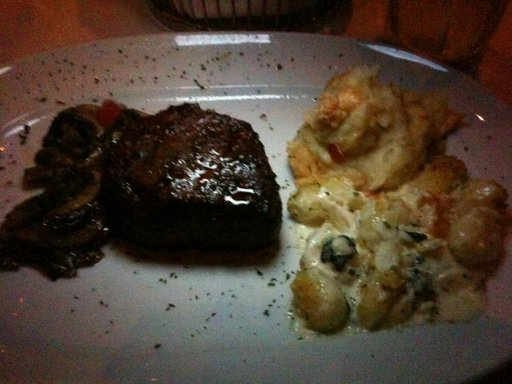

In [206]:
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
print(random_image_path)

img = Image.open(random_image_path)
img

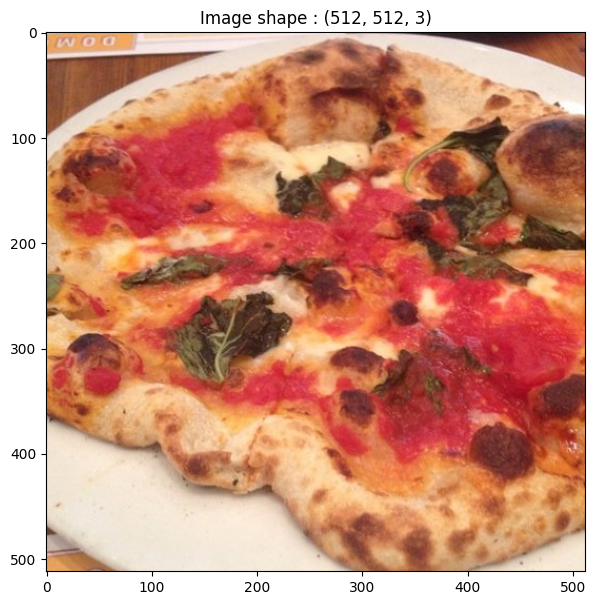

In [207]:
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)


img_as_array = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image shape : {img_as_array.shape}")
plt.show()

In [208]:
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [209]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [210]:
train_data = datasets.ImageFolder(root=train_dir,transform=data_transform,target_transform=None)
test_data = datasets.ImageFolder(root=test_dir,transform=data_transform,target_transform=None)

In [211]:
train_data.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [212]:
img, label = train_data[0][0],train_data[0][1]
print(img.shape)
print(train_data.classes[label])

torch.Size([3, 64, 64])
pizza


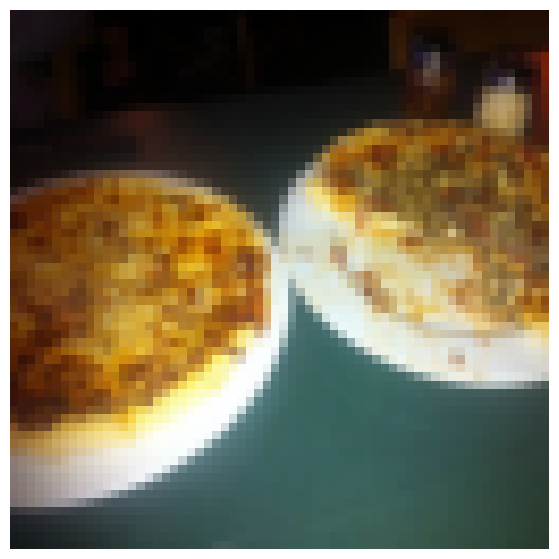

In [213]:
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0))
plt.axis(False)
plt.show()

In [214]:
#Turning datasets into dataloaders
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,batch_size=BATCH_SIZE,shuffle=True,num_workers=4)
test_dataloader = DataLoader(dataset=test_data,batch_size=BATCH_SIZE,shuffle=False,num_workers=4)

In [215]:
img,label = next(iter(train_dataloader))
print(f"Image shape: {img.shape}, label: {label.shape}")


Image shape: torch.Size([32, 3, 64, 64]), label: torch.Size([32])


In [216]:
target_dir = train_dir
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
class_names_found

['pizza', 'steak', 'sushi']

In [217]:
def find_classes(directory):
    class_names_found = sorted([entry.name for entry in list(os.scandir(directory))])
    class_to_idx = {class_name: i for i,class_name in enumerate(class_names_found)}
    return class_names_found,class_to_idx

In [218]:
from torch.utils.data import Dataset

class ImageFormat(Dataset):
    def __init__(self,targ_dir,transform=None):
        self.paths = list(Path(targ_dir).glob("*/*.jpg"))
        self.transform = transform
        self.classes,self.class_to_idx = find_classes(targ_dir)
    def load_image(self,index):
        image_path = self.paths[index]
        return Image.open(image_path)
    def __len__(self):
        return len(self.paths)
    def __getitem__(self,index):
        img = self.load_image(index)
        class_name = self.paths[index].parent.name
        class_idx = self.class_to_idx[class_name]
        if self.transform:
            return self.transform(img),class_idx
        else:
            return img,class_idx

In [219]:
train_data_custom = ImageFormat(targ_dir=target_dir, transform=data_transform)
len(train_data_custom)

225

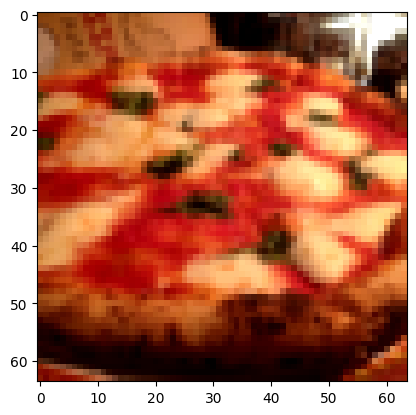

In [220]:
plt.imshow(train_data[1][0].permute(1,2,0))

In [240]:
class TinyVgg(nn.Module):
    def __init__(self,input_shape,output_shape,hidden_units):
        super().__init__()
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2),
        )
        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.MaxPool2d(kernel_size=2),
        )
        self.flatten_layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*8*8,
                      out_features=output_shape)
        )
    def forward(self,x):
        return self.flatten_layer(self.conv_block3(self.conv_block2(self.conv_block1(x))))

In [241]:
model1 = TinyVgg(input_shape=3,hidden_units=20,output_shape=len(class_names_found)).to(device)

In [242]:
from torchinfo import summary
summary(model1,input_size=[32,3,64,64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVgg                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 20, 32, 32]          --
│    └─Conv2d: 2-1                       [32, 20, 64, 64]          560
│    └─ReLU: 2-2                         [32, 20, 64, 64]          --
│    └─Conv2d: 2-3                       [32, 20, 64, 64]          3,620
│    └─ReLU: 2-4                         [32, 20, 64, 64]          --
│    └─MaxPool2d: 2-5                    [32, 20, 32, 32]          --
├─Sequential: 1-2                        [32, 20, 16, 16]          --
│    └─Conv2d: 2-6                       [32, 20, 32, 32]          3,620
│    └─ReLU: 2-7                         [32, 20, 32, 32]          --
│    └─Conv2d: 2-8                       [32, 20, 32, 32]          3,620
│    └─MaxPool2d: 2-9                    [32, 20, 16, 16]          --
├─Sequential: 1-3                        [32, 20, 8, 8]            --
│    

In [243]:
def train_step(model,train_dataloader,loss_fn,optimizer):
    train_loss = 0
    model.train()
    for batch,(X,y) in enumerate(train_dataloader):
        X,y = X.to(device),y.to(device)
        y_logits = model(X)
        loss = loss_fn(y_logits,y)
        train_loss+=loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader)
    print(f"Train loss: {train_loss}")

In [244]:
from tqdm.auto import tqdm

def test_step(model,test_dataloader,loss_fn):
    test_loss = 0
    model.eval()
    with torch.inference_mode():
        for X,y in test_dataloader:
            X,y = X.to(device),y.to(device)
            test_pred = model(X)
            loss = loss_fn(test_pred,y)
            test_loss += loss
        test_loss/=len(test_dataloader)
        return test_loss

In [245]:
loss_fn = nn.CrossEntropyLoss()
lr = 0.01
optimizer = torch.optim.Adam(params=model1.parameters(),lr=lr)


In [247]:
epochs = 5
loss = []
for epoch in tqdm(range(epochs)):
    print(f"Epoch : {epoch}")
    train_step(model1,train_dataloader,loss_fn,optimizer)
    x = test_step(model1,test_dataloader,loss_fn)
    loss.append(x)
    

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 0
Train loss: 1.5148601531982422


 20%|██        | 1/5 [00:07<00:29,  7.41s/it]

Epoch : 1
Train loss: 1.3340554237365723


 40%|████      | 2/5 [00:14<00:22,  7.35s/it]

Epoch : 2
Train loss: 1.250294804573059


 60%|██████    | 3/5 [00:22<00:14,  7.37s/it]

Epoch : 3
Train loss: 1.2401514053344727


 80%|████████  | 4/5 [00:31<00:08,  8.02s/it]

Epoch : 4
Train loss: 1.1807317733764648


100%|██████████| 5/5 [00:39<00:00,  7.98s/it]


In [249]:
loss = [items.item() for items in loss]
loss

[1.7058790922164917,
 1.1442809104919434,
 1.107351303100586,
 1.3172857761383057,
 1.1412222385406494]